# Lensing rate based on SNR
## elliptical galaxy

In [1]:
import numpy as np
import bilby
import pylab as plt
from matplotlib import pyplot
import pycbc
from pycbc.detector import Detector
from datetime import datetime

# for fast SNR calculatiopn call quintet
from TaylorF2_with_fLim import quintet

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
# for redshift to luminosity distance conversion
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
import astropy.units as u

# Non-lensed events

## setting up the boolean function for detectability

* $SNR$ of an event has to be greater than some $SNR_{th}$
* $$\Theta[\rho(z,\theta)-\rho_{th}]=\begin{cases}
        1 & \rho(z,\theta)>\rho_{th}\\
        0 & \rho(z,\theta)<\rho_{th}
    \end{cases}$$
* where $\theta$ is the GW parameters

In [3]:
# initialised quintet for fast SNR calculation
quin_ = quintet(mtot_min=2., mtot_max=439.6, nsamples=100)

In [4]:
quin_.snr(mass_1=np.array([10.,50.,100.,500.]), mass_2=np.array([10.,50.,100.,500.]))['L1']

array([131.99949301, 261.78604139,  66.16504101,   0.        ])

In [5]:
def bool_unlensed(param,rho_th=8.):
    
    m1 = param['m1']
    m2 = param['m2']
    Dl = param['Dl']
    i = param['iota']
    psi = param['psi']
    phase = param['phase']
    ra = param['ra']
    dec = param['dec']
    # rho, has snr of network, L1, H1, V1 by default
    # but it also depent of the initialized number of detectors
    # for now lets consider only 'L1'
    rho = quin_.snr(mass_1=m1, mass_2=m2, luminosity_distance=Dl, iota=i, psi=psi, phase=phase, ra=ra, dec=dec)['L1']
    
    size = len(m1)
    bool_ = np.zeros(size)
    rho_th_arr =  np.ones(size)*rho_th
    bool_[rho>rho_th_arr] = 1.
    
    return(bool_)

In [6]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 10
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = np.random.uniform(100,1000,size=nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [7]:
param_ = {'m1':mass_1,'m2':mass_2,'Dl':luminosity_distance,'iota':theta_jn,'psi':psi,'phase':phase,'ra':ra,'dec':dec}

In [8]:
bool_unlensed(param_)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

## if the boolean is replaced by $P_{det}$

In [9]:
from scipy.special import erfc
from scipy.stats import norm

In [15]:
def pdet(param,rho_th=8.):
    
    m1 = param['m1']
    m2 = param['m2']
    Dl = param['Dl']
    i = param['iota']
    psi = param['psi']
    phase = param['phase']
    ra = param['ra']
    dec = param['dec']
    # rho, has snr of network, L1, H1, V1 by default
    # but it also depent of the initialized number of detectors
    # for now lets consider only 'L1'
    rho = quin_.snr(mass_1=m1, mass_2=m2, luminosity_distance=Dl, iota=i, psi=psi, phase=phase, ra=ra, dec=dec)['L1']
    
    size = len(m1)
    rho_th_arr =  np.ones(size)*rho_th
    buffer = (rho-rho_th_arr)/1.4142135623730951
    pdet_arr = 0.5*erfc(buffer)
    
    return(pdet_arr, (rho-rho_th_arr)/1.4142135623730951, rho)

In [10]:
def pdet(param,rho_th=8.):
    
    m1 = param['m1']
    m2 = param['m2']
    Dl = param['Dl']
    i = param['iota']
    psi = param['psi']
    phase = param['phase']
    ra = param['ra']
    dec = param['dec']
    # rho, has snr of network, L1, H1, V1 by default
    # but it also depent of the initialized number of detectors
    # for now lets consider only 'L1'
    rho = quin_.snr(mass_1=m1, mass_2=m2, luminosity_distance=Dl, iota=i, psi=psi, phase=phase, ra=ra, dec=dec)['L1']
    
    P_ = 1 - norm.cdf(rho_th - rho)
    return(P_)

In [11]:
pdet(param_)

array([9.99998988e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 6.66133815e-16])

# BBH/BNS merger rate

* merger rate as given in https://arxiv.org/pdf/2106.06303.pdf: 
$$ \mathcal{R}_m(z_s) = \frac{\mathcal{R}_O(b_4+1)e^{b_2 z_s}}{b_4+e^{b_3 z_s}} \text{Gpc}^{-3}\text{yr}^{-1}$$
* $z_s$: redshift of source
* $\mathcal{R}$: local mergerrate. $\mathcal{R}=23.9^{+14.3}_{-8.6}\text{Gpc}^{-3}\text{yr}^{-1}==23.9^{+14.3}_{-8.6} \times 10^{-9}\text{Mpc}^{-3}\text{yr}^{-1}$
* fitting parameters: $b_2=1.6$, $b_3=2.1$, $b_4=30$

In [12]:
# the value of local merger density rate R0 doesnt matter in the end as we are intersted only in rate ratio
def merger_rate_desity(zs, R0=23.*1e-9, b2=1.6, b3=2.1, b4=30):
    '''
    input parameters:
    zs (redshift of source)
    Return: 
    rate (merger rate in Mpc^-3 yr^-1)
    '''
    rate = R0*(b4+1)*np.exp(b2*zs)/(b4+np.exp(b3*zs))
    return(rate)

In [13]:
merger_rate_desity(np.array([0.03,0.02,0.01]))

array([2.40804130e-08, 2.37150882e-08, 2.33549714e-08])

# BBH distribution (powerlaw+peak model)

* $ p(m_1,q|\theta_{pop}) = p(q|m_1,\theta_{pop}) \, p(m_1|\theta_{pop}) $
* $\theta_{pop}$ is the population parameters

$$ p(m_1|\lambda_{peak},\alpha,m_{max},m_{min},\delta_m,\mu_m,\sigma_m) = [ (1-\lambda_{peak})\mathcal{B}(m_1|-\alpha,m_{max})+\lambda_{peak} G(m_1|\mu_m,\sigma_m) ] S(m_1|m_{min},\delta_m)$$

* $\mathcal{B}$ : normalized powerlaw with spectral index $-\alpha$ and cut-off $m_{max}$
* G : gaussian distribution with mean $\mu_m$ and width $\sigma_m$
* S : smooothing function
$$S(m_1|m_{min},\delta_m) = \begin{cases}
        0 & : m_1<m_{min}\\
        \Big[\text{exp}\left( \frac{\delta_m}{m_1-m_{min}} + \frac{\delta_m}{m_1-m_{min}-\delta_m} \right)\Big]^{-1} & : m_{min} \leq m < m_{min}+\delta_m\\
        1 & : m \geq m_{min}+\delta_m
    \end{cases}$$
    
* lastly, 
$$ p(q|\beta,m_1,m_{min},\delta_m) \propto q^{\beta} S(q m_1|m_{min},\delta_m) $$

In [14]:
from gwcosmo import priors as p

In [19]:
Nsamples = 10000

model_pars_gwcosmo = {'alpha': 3.63, 'beta': 1.26, 'delta_m': 4.82, 'mmin': 4.59, 'mmax': 86.22, 'lambda_peak': 0.08, \
                      'mu_g': 33.07, 'sigma_g': 5.69}
model=p.mass_prior('BBH-powerlaw-gaussian', model_pars_gwcosmo)
m01, m02 = model.sample(Nsample=Nsamples)
while np.any(m02>m01):
    m01, m02 = model.sample(Nsample=Nsamples)

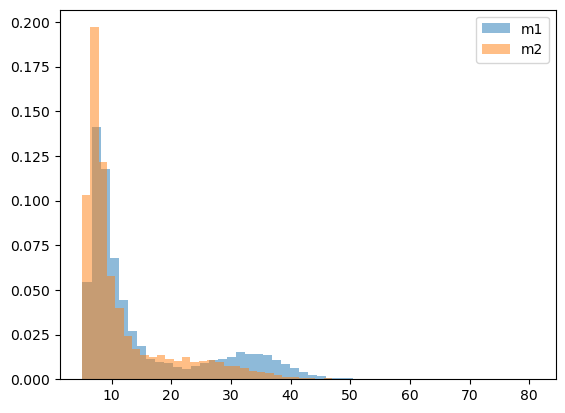

In [24]:
# looking at the mass distribution
plt.hist(m01, density=True, bins=50, alpha=0.5)
plt.hist(m02, density=True, bins=50, alpha=0.5)
plt.gca().legend(('m1','m2'))
plt.show()

# Differential comoving volume element 
* $ \frac{dV_c}{dz} $
* solid angle: $\Omega = \frac{A}{r^2}$
* integrate over the surface of a sphere: $\Omega = \frac{4 \pi r^2}{r^2} = 4 \pi$

In [25]:
def dVc_dz(z):
    return(4*np.pi*Planck18.differential_comoving_volume(z).value)

# Unlensed events' rate

$$ R_U = \int_{0}^{\infty}dz \frac{R_m(z)}{1+z} P(z) \frac{dV_c}{dz}\left\{\int_{2}^{\infty}\Theta[\rho(z,\theta)-\rho_{th}] P(\theta) d\theta \right\} $$
* $\theta \in \{m_1,m_2,D_l,\iota,\phi,\psi,ra,dec\}$
* sampling will be done wrt P_o(z) and P_o(m)

* $$ R_U = \left<  \frac{R_m(z)}{1+z} \frac{P(z)}{P_o(z)} \frac{dV_c}{dz} \frac{P(m)}{P_o(m)}\Theta[\rho(z,\theta)-\rho_{th}]\right>_{z,\theta \in \text{Uniform}[z,\theta]} $$
* $$ R_U = \left<  \frac{R_m(z)}{1+z} \frac{P(z)}{P_o(z)} \frac{dV_c}{dz} \frac{f(m)}{f_o(m)}P_{det}(z,\theta)\right>_{z,\theta \in \text{Uniform}[z,\theta]} $$
* $$ R_U = \sum_i \frac{R_m(z_i)}{1+z_i} \frac{P(z_i)}{1/(z_{max}-z_{min})} \frac{dV_c}{dz} \frac{f(m_i)}{1/(z_{max}-z_{min})}P_{det}(z_i,\theta_i)  $$


In [22]:
def integration1(n_samples=1000,m_min=5.,m_max=500.,z_min=0.,z_max=14.,):
    
    np.random.seed(100)
    mass_1 = np.random.uniform(m_min,m_max,size=nsamples)
    mass_2 = mass_1
    z = np.random.uniform(z_min,z_max,size=nsamples)
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
    ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), \
                            np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)

    param_ = {'m1':mass_1,'m2':mass_2,'Dl':Dl,'iota':theta_jn,'psi':psi,'phase':phase,'ra':ra,'dec':dec}
    pdet_ = pdet(param_)
    
    ans = np.sum(merger_rate_desity(z)*dVc_dz(z)*f_(mass_1)*pdet_)*(z_max-z_min)*(m_max-m_min)/n_samples**2

    return(ans)

In [23]:
integration1(n_samples=1000000)

3.609532803730542e-15

# Unlensed events' rate

$$ R_U = \int_{0}^{\infty}dz \frac{R_O g(z) \rho^{-1}}{1+z} \tau(z) \frac{dV_c}{dz}\left\{\int_{2}^{\infty}\Theta[\rho(z,\theta,\mu)-\rho_{th}] f(m) P(\mu) dm d\mu \right\} $$

* sampling will be done wrt $g(z)$, $P(\theta)$, $P(\mu)$

* $$ R_U = \left<  \frac{R(z)}{g_o(z)} \tau(z) \frac{dV_c}{dz}(z) \frac{f(m)}{f_o(m)} \frac{P(\mu)}{P_o(\mu)} P_{det}(z,\theta,\mu)\right>_{z,\theta,\mu \in \text{Uniform}[z,\theta,\mu]} $$

* Probability desity function of lens amplification (SIS model): $P(\mu)=\frac{2}{(-1+\mu)^3}$

In [53]:
def p_mu(mu):
    return(2/(-1+mu)**3)

# optical depth
* $\mathcal{D}_c$ : co-moving distance of the source
* as given in equation 18, https://arxiv.org/abs/2204.12977:
$$ \tau(z) = \left(\frac{\mathcal{D}_c(z)}{62.2Gpc}\right)^3 $$

In [52]:
def optical_depth(z):
    # z to luminosity_distance (Dl) conversion
    Dc = Planck18.comoving_distance(z).value*1e-3  # in Gpc
    return( (Dc/62.2)**3 )

In [85]:
def integration2(n_samples=1000,m_min=5.,m_max=500.,z_min=0.,z_max=14.,mu_min=2.,mu_max=1000.):
    
    np.random.seed(100)
    mass_1 = np.random.uniform(m_min,m_max,size=nsamples)
    mass_2 = mass_1
    z = np.random.uniform(z_min,z_max,size=nsamples)
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
    ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), \
                            np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)

    param_ = {'m1':mass_1,'m2':mass_2,'Dl':Dl,'iota':theta_jn,'psi':psi,'phase':phase,'ra':ra,'dec':dec}
    pdet_ = pdet(param_)
    
    mu = np.random.uniform(mu_min,mu_max,size=nsamples)
    
    ans = np.sum(merger_rate_desity(z)*optical_depth(z)*dVc_dz(z)*f_(mass_1)*p_mu(mu)*pdet_)*\
        (z_max-z_min)*(m_max-m_min)*(mu_max-mu_min)/n_samples**2

    return(ans)

In [86]:
integration2(n_samples=1000000)

9.745477615738677e-18

In [88]:
integration2(n_samples=1000000)/integration1(n_samples=1000000)*1e6

0.0026999277041246123